In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import files
files.upload()

Saving ita.txt to ita.txt


In [3]:
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text

In [4]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [5]:
data = read_text("ita.txt")
ita_eng = to_lines(data)
ita_eng = array(ita_eng)

In [6]:
ita_eng = ita_eng[:50000,:]

In [7]:
ita_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ita_eng[:,0]]
ita_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ita_eng[:,1]]

ita_eng

array([['Hi', 'Ciao',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['Run', 'Corri',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['Run', 'Corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['Love conquers all', 'Lamore conquista tutto',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #967096 (zipangu) & #5848764 (Guybrush88)'],
       ['Love will prevail', 'Lamore prevarrà',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1894273 (Spamster) & #2458085 (Guybrush88)'],
       ['Love will survive', 'Lamore sopravviverà',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2025441 (Spamster) & #4243335 (Guybrush88)']],
      dtype='<U537')

In [8]:
for i in range(len(ita_eng)):
    ita_eng[i,0] = ita_eng[i,0].lower()
    ita_eng[i,1] = ita_eng[i,1].lower()

ita_eng

array([['hi', 'ciao',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['run', 'corri',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['run', 'corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['love conquers all', 'lamore conquista tutto',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #967096 (zipangu) & #5848764 (Guybrush88)'],
       ['love will prevail', 'lamore prevarrà',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1894273 (Spamster) & #2458085 (Guybrush88)'],
       ['love will survive', 'lamore sopravviverà',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2025441 (Spamster) & #4243335 (Guybrush88)']],
      dtype='<U537')

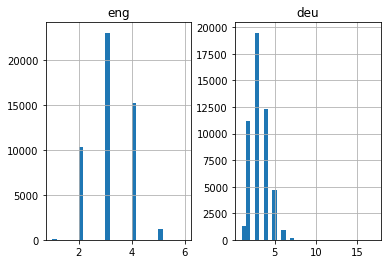

In [9]:
eng_l = []
ita_l = []

for i in ita_eng[:,0]:
      eng_l.append(len(i.split()))

for i in ita_eng[:,1]:
      ita_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':ita_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
eng_tokenizer = tokenization(ita_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4219


In [12]:
ita_tokenizer = tokenization(ita_eng[:, 1])
ita_vocab_size = len(ita_tokenizer.word_index) + 1

ita_length = 8
print('Deutch Vocabulary Size: %d' % ita_vocab_size)

Deutch Vocabulary Size: 9706


In [13]:
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ita_eng, test_size=0.2, random_state = 12)

In [15]:
trainX = encode_sequences(ita_tokenizer, ita_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(ita_tokenizer, ita_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
model = define_model(ita_vocab_size, eng_vocab_size, ita_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 41s 86ms/step - loss: 3.8818 - val_loss: 2.3356

Epoch 00001: val_loss improved from inf to 2.33562, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 2.2886 - val_loss: 2.2243

Epoch 00002: val_loss improved from 2.33562 to 2.22426, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 3/30
63/63 [==============================] - 4s 62ms/step - loss: 2.1251 - val_loss: 2.0345

Epoch 00003: val_loss improved from 2.22426 to 2.03452, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 4/30
63/63 [==============================] - 4s 64ms/step - loss: 1.9347 - val_loss: 1.8794

Epoch 00004: val_loss improved from 2.03452 to 1.87935, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 1.7509 - val_loss: 1.7207

Epoch 00005: val_loss improved from 1.87935 to 1.72065, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 6/30
63/63 [==============================] - 4s 63ms/step - loss: 1.5978 - val_loss: 1.6006

Epoch 00006: val_loss improved from 1.72065 to 1.60061, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 1.4504 - val_loss: 1.4841

Epoch 00007: val_loss improved from 1.60061 to 1.48406, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 8/30
63/63 [==============================] - 4s 63ms/step - loss: 1.3201 - val_loss: 1.3962

Epoch 00008: val_loss improved from 1.48406 to 1.39617, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 9/30
63/63 [==============================] - 4s 63ms/step - loss: 1.1925 - val_loss: 1.3066

Epoch 00009: val_loss improved from 1.39617 to 1.30658, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 10/30
63/63 [==============================] - 4s 63ms/step - loss: 1.0785 - val_loss: 1.2572

Epoch 00010: val_loss improved from 1.30658 to 1.25721, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 11/30
63/63 [==============================] - 4s 63ms/step - loss: 0.9871 - val_loss: 1.1550

Epoch 00011: val_loss improved from 1.25721 to 1.15501, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 12/30
63/63 [==============================] - 4s 63ms/step - loss: 0.8951 - val_loss: 1.1056

Epoch 00012: val_loss improved from 1.15501 to 1.10556, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 13/30
63/63 [==============================] - 4s 63ms/step - loss: 0.8075 - val_loss: 1.0484

Epoch 00013: val_loss improved from 1.10556 to 1.04841, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 14/30
63/63 [==============================] - 4s 64ms/step - loss: 0.7346 - val_loss: 1.0055

Epoch 00014: val_loss improved from 1.04841 to 1.00550, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 15/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6615 - val_loss: 0.9495

Epoch 00015: val_loss improved from 1.00550 to 0.94947, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 16/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5922 - val_loss: 0.9304

Epoch 00016: val_loss improved from 0.94947 to 0.93044, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 17/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5384 - val_loss: 0.8801

Epoch 00017: val_loss improved from 0.93044 to 0.88014, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 18/30
63/63 [==============================] - 4s 64ms/step - loss: 0.4819 - val_loss: 0.8436

Epoch 00018: val_loss improved from 0.88014 to 0.84363, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 19/30
63/63 [==============================] - 4s 65ms/step - loss: 0.4314 - val_loss: 0.8240

Epoch 00019: val_loss improved from 0.84363 to 0.82397, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 20/30
63/63 [==============================] - 4s 65ms/step - loss: 0.3867 - val_loss: 0.7883

Epoch 00020: val_loss improved from 0.82397 to 0.78833, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 21/30
63/63 [==============================] - 4s 66ms/step - loss: 0.3433 - val_loss: 0.7761

Epoch 00021: val_loss improved from 0.78833 to 0.77613, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 22/30
63/63 [==============================] - 4s 65ms/step - loss: 0.3137 - val_loss: 0.7436

Epoch 00022: val_loss improved from 0.77613 to 0.74359, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 23/30
63/63 [==============================] - 4s 65ms/step - loss: 0.2830 - val_loss: 0.7307

Epoch 00023: val_loss improved from 0.74359 to 0.73068, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 24/30
63/63 [==============================] - 4s 66ms/step - loss: 0.2548 - val_loss: 0.7224

Epoch 00024: val_loss improved from 0.73068 to 0.72239, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 25/30
63/63 [==============================] - 4s 65ms/step - loss: 0.2305 - val_loss: 0.6998

Epoch 00025: val_loss improved from 0.72239 to 0.69982, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 26/30
63/63 [==============================] - 4s 66ms/step - loss: 0.2067 - val_loss: 0.6898

Epoch 00026: val_loss improved from 0.69982 to 0.68976, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 27/30
63/63 [==============================] - 4s 65ms/step - loss: 0.1875 - val_loss: 0.6891

Epoch 00027: val_loss improved from 0.68976 to 0.68915, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 28/30
63/63 [==============================] - 4s 65ms/step - loss: 0.1695 - val_loss: 0.6916

Epoch 00028: val_loss did not improve from 0.68915
Epoch 29/30
63/63 [==============================] - 4s 64ms/step - loss: 0.1560 - val_loss: 0.6667

Epoch 00029: val_loss improved from 0.68915 to 0.66672, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


Epoch 30/30
63/63 [==============================] - 4s 65ms/step - loss: 0.1410 - val_loss: 0.6666

Epoch 00030: val_loss improved from 0.66672 to 0.66661, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1/assets


INFO:tensorflow:Assets written to: model.h1/assets


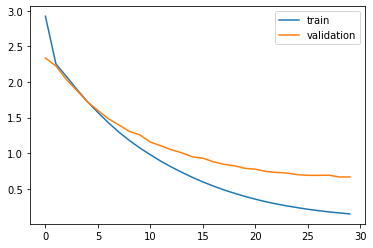

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [23]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [25]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
6024,tom is groggy,toms is
9109,youre fine,youre ok
570,i saw her again,i saw her again
4882,i have to think,i must to hide
5652,is this enough,this is painful
9896,its all over,its done
8041,tom seems tough,tom seems tough
8731,youre decisive,youre realistic
8139,im a student,im am a student
3956,im thirsty,im thirsty
